In [51]:
import os
import re
import glob
import struct
from os import makedirs

import numpy as np
from numpy import asarray
from numpy import zeros
from nltk.stem.porter import *


import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Embedding, Concatenate, Conv1D
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import regularizers
from keras import backend as K
from keras.models import load_model

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import layers


Load the Dataset


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
os.chdir("/content/drive/MyDrive/twit/train")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "aggregate.csv", index=False, encoding='utf-8-sig')

In [36]:
train = pd.read_csv('/content/drive/MyDrive/twit/train/aggregate.csv')

train.head()

,Column1,Column2,Column3
0,6.200000e+17,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,6.200000e+17,neutral,Order Go Set a Watchman in store or through ou...
2,6.200000e+17,negative,If these runway renovations at the airport pre...
3,6.200000e+17,neutral,If you could ask an onstage interview question...
4,6.200000e+17,positive,A portion of book sales from our Harper Lee/Go...


Data Preprocessing

In [38]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

In [41]:
train_set = clean_tweets(train, 'Column3', remove_stop_words=False, remove_special=False)
train_set.head()

,Column1,Column2,Column3,Tweet_Clean_Text
0,6.200000e+17,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...","picturehouse's, pink floyd's, 'roger waters: t..."
1,6.200000e+17,neutral,Order Go Set a Watchman in store or through ou...,order go set a watchman in store or through ou...
2,6.200000e+17,negative,If these runway renovations at the airport pre...,if these runway renovations at the airport pre...
3,6.200000e+17,neutral,If you could ask an onstage interview question...,if you could ask an onstage interview question...
4,6.200000e+17,positive,A portion of book sales from our Harper Lee/Go...,a portion of book sales from our harper lee/go...


In [42]:
train_set["Sentiment_Value"] = train_set["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
label = to_categorical(train_set["Sentiment_Value"], 3)
train_set

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,6.200000e+17,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...","picturehouse's, pink floyd's, 'roger waters: t...",0
1,6.200000e+17,neutral,Order Go Set a Watchman in store or through ou...,order go set a watchman in store or through ou...,0
2,6.200000e+17,negative,If these runway renovations at the airport pre...,if these runway renovations at the airport pre...,2
3,6.200000e+17,neutral,If you could ask an onstage interview question...,if you could ask an onstage interview question...,0
4,6.200000e+17,positive,A portion of book sales from our Harper Lee/Go...,a portion of book sales from our harper lee/go...,1
...,...,...,...,...,...
114213,4.277950e+17,positive,Goodnight!!!! Aral2 din pag may time! LOGIC is...,goodnight!!!! aral2 din pag may time! logic is...,1
114214,4.381630e+17,positive,This week just keeps getting better and better...,this week just keeps getting better and better...,1
114215,4.256920e+17,negative,RT @akrongarber: @moraro456 The 1st gay presid...,the 1st gay president and the 1st dope head p...,2
114216,4.264920e+17,negative,Oh is there really a 2 hour delay tomorrow oh ...,oh is there really a 2 hour delay tomorrow oh ...,2


In [43]:
train['l'] = train_set['Tweet_Clean_Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train.l.mean()))
print("max length of sentence: " + str(train.l.max()))
print("std dev length of sentence: " + str(train.l.std()))

mean length of sentence: 16.71109632457231
max length of sentence: 40.0
std dev length of sentence: 6.5991113050835795


In [44]:
sequence_length = train.l.max() #using the maximum length 

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_set['Tweet_Clean_Text'].values)

X = tokenizer.texts_to_sequences(train_set['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=int(sequence_length), padding='post')

print("training size " + str(len(X)))

voc_size = len(tokenizer.word_index) + 1
print("Vocab size: ", voc_size)
print("Input shape: ", X.shape)
print("Labels shape: " , label.shape)

training size 114218
Vocab size:  73456
Input shape:  (114218, 40)
Labels shape:  (114218, 3)


Spliting the dataset

In [71]:
#FINAL DATASETS (Please note case sensitivity)- TRAINING: (X_train,Y_train)  VALIDATION: (X_val, Y_val)  TEST: (X_test, Y_test)

x_train, X_test, y_train, Y_test = train_test_split(X, label, test_size=0.10, shuffle=False, random_state=10)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True, random_state=10)

GloVe Embedding

In [75]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [76]:
embedding_dim = 200
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Metrics

In [77]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [78]:
def model_gen(filter_sizes, model_save_path):

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath= model_save_path + str(filter_sizes) + '.h5',
      save_weights_only = False,
      monitor = 'val_f1_metrics',
      mode= 'max',
      save_best_only= True,
      save_freq='epoch'
  )

  early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

  reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)

  output_dims = 200
  lstm_out = filter_sizes

  model = keras.Sequential([
      layers.Embedding(input_dim=voc_size, output_dim=output_dims, input_length=X.shape[1], weights=[embedding_matrix]),
      layers.SpatialDropout1D(0.2),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)),
      layers.Dense(units=3, activation='softmax')
      ])

  metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
  ]

  model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=metrics
              )

  history = model.fit(X_train,
                      Y_train,
                      batch_size=3000,
                      epochs=20,
                      validation_data=(X_val,Y_val),
                      shuffle=True,
                      callbacks=[model_checkpoint, early_stopping_callback, reduce_lr_callback]
  )

  return model, history

In [ ]:
filter_sizes = [
                200,256,352,456,532
                ]
models = []
best_indiv = 0.0
for filter_size in filter_sizes:
  model, history = model_gen(filter_size, 'models/LSTM')
  models.append(model)
  best_indiv = max(best_indiv, max(history.history['val_f1_metrics']))

In [80]:
for i, model in enumerate(models):
  print("\nModel_{0}".format(i))
  model.evaluate(X_test, Y_test, batch_size=1000)


Model_0
12/12 [==============================] - 1s 120ms/step - loss: 0.8104 - categorical_accuracy: 0.6599 - precision: 0.6745 - recall: 0.6403 - f1_metrics: 0.6522

Model_1
12/12 [==============================] - 2s 133ms/step - loss: 0.7744 - categorical_accuracy: 0.6544 - precision: 0.6732 - recall: 0.6311 - f1_metrics: 0.6463

Model_2
12/12 [==============================] - 2s 174ms/step - loss: 0.7733 - categorical_accuracy: 0.6580 - precision: 0.6769 - recall: 0.6375 - f1_metrics: 0.6517

Model_3
12/12 [==============================] - 3s 217ms/step - loss: 0.8062 - categorical_accuracy: 0.6621 - precision: 0.6761 - recall: 0.6382 - f1_metrics: 0.6514


In [81]:
best_indiv

0.7248726487159729

In [82]:
train_predictions_LSTM = []
test_predictions_LSTM = []

for model in models:
  train_predictions_LSTM.append(model.predict([X_train], batch_size=1024))
  test_predictions_LSTM.append(model.predict([X_val], batch_size=1024))

In [83]:
ndarray = np.array(train_predictions_LSTM)
positive = ndarray[:,:,0]
neutral = ndarray[:,:,1]
negative = ndarray[:,:,2]

average = (np.corrcoef(positive) + np.corrcoef(neutral) + np.corrcoef(negative))/3
average

array([[1.        , 0.98609026, 0.98519613, 0.98165782],
       [0.98609026, 1.        , 0.99040764, 0.97987778],
       [0.98519613, 0.99040764, 1.        , 0.97581993],
       [0.98165782, 0.97987778, 0.97581993, 1.        ]])

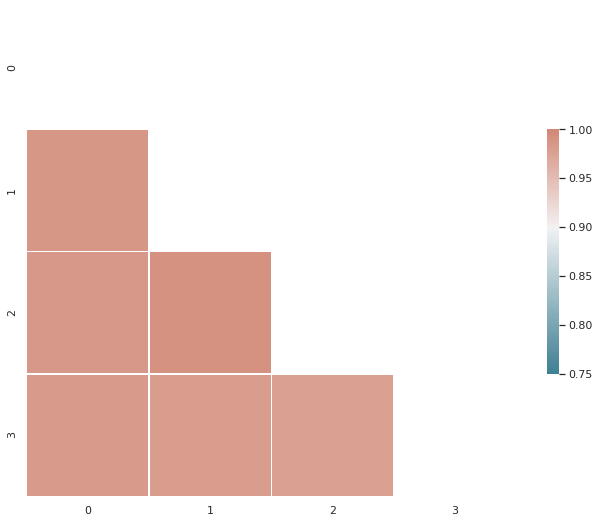

In [84]:
import seaborn as sns

sns.set_theme(style="white")

mask = np.triu(np.ones_like(average, dtype=bool))

f, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(220,20, n=9, as_cmap=True)

sns.heatmap(average, mask=mask, cmap=cmap, vmax=1, vmin=.75, center=.9,
            square=True, linewidth=.5, cbar_kws={"shrink":.5})